# abular Classification with Amazon SageMaker TabTransformer algorithm

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|tabtransformer_tabular|Amazon_Tabular_Regression_TabTransformer.ipynb)

---

---
This notebook demonstrates the use of Amazon SageMaker [TabTransformer](https://arxiv.org/abs/2012.06678) algorithm to train and host a tabular regression model. Tabular regression is the task of analyzing the relationship between predictor variables and a response variable in a structured or relational data.

In this notebook, we demonstrate two use cases of tabular regression models:

* How to train a tabular model on an example dataset to do regression.
* How to use the trained tabular model to perform inference, i.e., predicting new samples.

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Train A Tabular Model on Abalone Dataset](#2.-Train-a-Tabular-Model-on-Abalone-Dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training Parameters](#2.2.-Set-Training-Parameters)
    * [Train with Automatic Model Tuning](#2.3.-Train-with-Automatic-Model-Tuning)    
    * [Start Training](#2.4.-Start-Training)
3. [Deploy and Run Inference on the Trained Tabular Model](#3.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
4. [Evaluate the Prediction Results Returned from the Endpoint](#4.-Evaluate-the-Prediction-Results-Returned-from-the-Endpoint)

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.

---

In [1]:
!pip install sagemaker ipywidgets openpyxl --upgrade --quiet


---
To train and host on Amazon SageMaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3.

---

In [2]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## 2. Train a Tabular Model on Telco data

---

In this demonstration, we will train a tabular algorithm on the [IBM's Telecom Churn Data](https://www.kaggle.com/datasets/ylchang/telco-customer-churn-1113/data) dataset.


### 2.1. Retrieve Training Artifacts

___

Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have one choice in this demonstration.
* [TabTransformer](https://arxiv.org/abs/2012.06678): To use this algorithm, specify `train_model_id` as `pytorch-tabtransformerregression-model` in the cell below.

Note. [LightGBM](https://lightgbm.readthedocs.io/en/latest/) (`train_model_id: lightgbm-regression-model`), [CatBoost](https://catboost.ai/en/docs/) (`train_model_id:catboost-regression-model`), [XGBoost](https://xgboost.readthedocs.io/en/latest/) (`train_model_id: xgboost-regression-model`), [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (`train_model_id: sklearn-regression-linear`), and [AutoGluon Tabular](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html) (`train_model_id: autogluon-regression-ensemble`) are the other choices in the tabular regression category. Since they have different input-format requirements, please check separate notebooks `lightgbm_catboost_tabular/Amazon_Tabular_Regression_LightGBM_CatBoost.ipynb`, `xgboost_linear_learner_tabular/Amazon_Tabular_Regression_XGBoost_LinearLearner.ipynb`, and `autogluon_tabular/Amazon_Tabular_Regression_AutoGluon.ipynb` for details.

---

In [3]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = (
    "pytorch-tabtransformerclassification-model",
    "*",
    "training",
)
training_instance_type = "ml.m5.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune. In tabular case, however, the pre-trained model tarball is dummy and fine-tune means training from scratch.
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Using model 'pytorch-tabtransformerclassification-model' with wildcard version identifier '*'. You can pin to version '2.0.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


## 2.3 Investigate Data (EDA)

### Set Training Parameters and get the Data Preprocessing

---
Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [4]:
# Download the data
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


raw_data_prefix = "telco/raw"

training_data_file_name = "Telco_customer_churn.xlsx"

data_bucket = "sagemaker-us-east-1-397799416488"

boto3.client("s3").upload_file(
    f"./{training_data_file_name}",
    data_bucket,
    f"{raw_data_prefix}/train/{training_data_file_name}"
)


In [5]:
# import os

# def download_dir(client, resource, dist, local='/tmp', bucket='your_bucket'):
#     paginator = client.get_paginator('list_objects')
#     for result in paginator.paginate(Bucket=bucket, Delimiter='/', Prefix=dist):
#         if result.get('CommonPrefixes') is not None:
#             for subdir in result.get('CommonPrefixes'):
#                 download_dir(client, resource, subdir.get('Prefix'), local, bucket)
#         for file in result.get('Contents', []):
#             dest_pathname = os.path.join(local, file.get('Key'))
#             if not os.path.exists(os.path.dirname(dest_pathname)):
#                 os.makedirs(os.path.dirname(dest_pathname))
#             if not file.get('Key').endswith('/'):
#                 resource.meta.client.download_file(bucket, file.get('Key'), dest_pathname)

# client = boto3.client('s3')
# resource = boto3.resource('s3')
# example_bucket = f"jumpstart-cache-prod-{aws_region}"
# download_dir(client, resource, 'training-datasets/tabular_binary/', 'tmp/', bucket=example_bucket)

In [6]:
train = pd.read_excel('./Telco_customer_churn.xlsx')

In [7]:
print(f"Data Shape: {train.shape}")
train.info()
train.head()

Data Shape: (7043, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  I

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [8]:
train_churn_rate = train["Churn Value"].value_counts() / len(train)
print(f"Train Churn: {train_churn_rate}")

Train Churn: Churn Value
0    0.73463
1    0.26537
Name: count, dtype: float64


### Handle Missing Data

In [9]:
print("Missing Data")
missing = list()
for x in train.columns:
    null_sum = train[x].isnull().sum()
    if null_sum != 0:
        print(x, null_sum)
        missing.append(x)

Missing Data
Churn Reason 5174


We're replacing missing values with zeros instead of removing them. Another method is filling missing values with a single number like zero, or through imputation or interpolation from existing values. Pandas simplifies this with the fillna() method, replacing null values with a specified value.

In [10]:
train.replace(np.nan, 0, inplace=True)

print(train)

      CustomerID  Count        Country       State          City  Zip Code  \
0     3668-QPYBK      1  United States  California   Los Angeles     90003   
1     9237-HQITU      1  United States  California   Los Angeles     90005   
2     9305-CDSKC      1  United States  California   Los Angeles     90006   
3     7892-POOKP      1  United States  California   Los Angeles     90010   
4     0280-XJGEX      1  United States  California   Los Angeles     90015   
...          ...    ...            ...         ...           ...       ...   
7038  2569-WGERO      1  United States  California       Landers     92285   
7039  6840-RESVB      1  United States  California      Adelanto     92301   
7040  2234-XADUH      1  United States  California         Amboy     92304   
7041  4801-JZAZL      1  United States  California  Angelus Oaks     92305   
7042  3186-AJIEK      1  United States  California  Apple Valley     92308   

                    Lat Long   Latitude   Longitude  Gender  ..

### Feature Engineering

In [11]:
from sklearn.preprocessing import OrdinalEncoder

# Drop customerID as it's unique for every value
# Drop count, country, state as it's same for all
# Drop lat, long as we have zip code
# Drop Churn Label as we have Churn Value
# Drop Churn Reason as it's implicit

train_target = train.drop(columns=['CustomerID','Count', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Reason'], axis=1)
train_target.rename(columns={"Churn Value": "Churn"}, inplace=True)

print(train_target.nunique())


Country                 1
State                   1
City                 1129
Zip Code             1652
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1585
Total Charges        6531
Churn                   2
Churn Score            85
CLTV                 3438
dtype: int64


In [12]:
# Encode binary columns
columns_to_encode = [
    'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
    'Paperless Billing'
]

encoder = OrdinalEncoder()

# Fit and transform the specified columns
encoded_values = encoder.fit_transform(train_target[columns_to_encode]) + 1

# Replace the original columns with the encoded values in the DataFrame
train_target[columns_to_encode] = encoded_values


In [13]:
train_target.head()

,Country,State,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn,Churn Score,CLTV
0,United States,California,Los Angeles,90003,2.0,1.0,1.0,1.0,2,2.0,...,No,No,Month-to-month,2.0,Mailed check,53.85,108.15,1,86,3239
1,United States,California,Los Angeles,90005,1.0,1.0,1.0,2.0,2,2.0,...,No,No,Month-to-month,2.0,Electronic check,70.70,151.65,1,67,2701
2,United States,California,Los Angeles,90006,1.0,1.0,1.0,2.0,8,2.0,...,Yes,Yes,Month-to-month,2.0,Electronic check,99.65,820.5,1,86,5372
3,United States,California,Los Angeles,90010,1.0,1.0,2.0,2.0,28,2.0,...,Yes,Yes,Month-to-month,2.0,Electronic check,104.80,3046.05,1,84,5003
4,United States,California,Los Angeles,90015,2.0,1.0,1.0,2.0,49,2.0,...,Yes,Yes,Month-to-month,2.0,Bank transfer (automatic),103.70,5036.3,1,89,5340


### (Optional) Turn Categorised Items to Numbers for easier processing for MLP to use as a baseline

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df

In [15]:
train_mlp = FunLabelEncoder(train_target.copy())
train_mlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            7043 non-null   int64  
 1   State              7043 non-null   int64  
 2   City               7043 non-null   int64  
 3   Zip Code           7043 non-null   int64  
 4   Gender             7043 non-null   float64
 5   Senior Citizen     7043 non-null   float64
 6   Partner            7043 non-null   float64
 7   Dependents         7043 non-null   float64
 8   Tenure Months      7043 non-null   int64  
 9   Phone Service      7043 non-null   float64
 10  Multiple Lines     7043 non-null   int64  
 11  Internet Service   7043 non-null   int64  
 12  Online Security    7043 non-null   int64  
 13  Online Backup      7043 non-null   int64  
 14  Device Protection  7043 non-null   int64  
 15  Tech Support       7043 non-null   int64  
 16  Streaming TV       7043 

In [16]:
train_mlp.head()

,Country,State,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn,Churn Score,CLTV
0,0,0,562,90003,2.0,1.0,1.0,1.0,2,2.0,...,0,0,0,2.0,3,53.85,157,1,86,3239
1,0,0,562,90005,1.0,1.0,1.0,2.0,2,2.0,...,0,0,0,2.0,2,70.70,925,1,67,2701
2,0,0,562,90006,1.0,1.0,1.0,2.0,8,2.0,...,2,2,0,2.0,2,99.65,6104,1,86,5372
3,0,0,562,90010,1.0,1.0,2.0,2.0,28,2.0,...,2,2,0,2.0,2,104.80,2646,1,84,5003
4,0,0,562,90015,2.0,1.0,1.0,2.0,49,2.0,...,2,2,0,2.0,0,103.70,4265,1,89,5340


### Create the cat_index.json for categorical values

In [17]:
# Move Churn to first column
churn_col = train_target.pop("Churn")
train_target.insert(0, churn_col.name, churn_col)

print(train_target.head())

   Churn        Country       State         City  Zip Code  Gender  \
0      1  United States  California  Los Angeles     90003     2.0   
1      1  United States  California  Los Angeles     90005     1.0   
2      1  United States  California  Los Angeles     90006     1.0   
3      1  United States  California  Los Angeles     90010     1.0   
4      1  United States  California  Los Angeles     90015     2.0   

   Senior Citizen  Partner  Dependents  Tenure Months  ...  Tech Support  \
0             1.0      1.0         1.0              2  ...            No   
1             1.0      1.0         2.0              2  ...            No   
2             1.0      1.0         2.0              8  ...            No   
3             1.0      2.0         2.0             28  ...           Yes   
4             1.0      1.0         2.0             49  ...            No   

  Streaming TV Streaming Movies        Contract Paperless Billing  \
0           No               No  Month-to-month      

In [18]:
train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Churn              7043 non-null   int64  
 1   Country            7043 non-null   object 
 2   State              7043 non-null   object 
 3   City               7043 non-null   object 
 4   Zip Code           7043 non-null   int64  
 5   Gender             7043 non-null   float64
 6   Senior Citizen     7043 non-null   float64
 7   Partner            7043 non-null   float64
 8   Dependents         7043 non-null   float64
 9   Tenure Months      7043 non-null   int64  
 10  Phone Service      7043 non-null   float64
 11  Multiple Lines     7043 non-null   object 
 12  Internet Service   7043 non-null   object 
 13  Online Security    7043 non-null   object 
 14  Online Backup      7043 non-null   object 
 15  Device Protection  7043 non-null   object 
 16  Tech Support       7043 

In [20]:
# Select columns with object dtype, which are usually categorical
categorical_columns = train_target.select_dtypes(include=['object']).columns

# Get the column indexes
categorical_indexes = [train_target.columns.get_loc(col) for col in categorical_columns]

# Display the categorical column indexes
print(categorical_indexes)

[1, 2, 3, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23]


### Split the data for training and validation

In [21]:
from sklearn.model_selection import train_test_split
# 80/20 split
train_data, validation_data = train_test_split(train_target, test_size=0.2, random_state=42)

print('train shape: ', train_data.shape)
print('validation shape: ', validation_data.shape)

train shape:  (5634, 26)
validation shape:  (1409, 26)


#### Requirements for the training data

A S3 path should contain two sub-directories 'train/', 'validation/' (optional), and a json-format file named 'categorical_index.json' (optional). Each sub-directory contains a 'data.csv' file (The ABALONE dataset used in this example has been prepared and saved in `training_dataset_s3_path` shown below).

* The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each boosting iteration. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a 20% of training data is randomly sampled to serve as the validation data.

* The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features).

* If the predictors include categorical feature(s), a json-format file named 'categorical_index.json' should be included in the input directory to indicate the column index(es) of the categorical features. Within the json-format file, it should have a python directory where the key is a string of 'cat_index_list' and the value is a list of unique integer(s). Each integer in the list indicates the column index of categorical features in the 'data.csv'. The range of each integer should be more than 0 (index 0 indicates the target) and less than the total number of columns. If the data set does not contain any categorical feature, the TabTransformer algorithm is equivalently a multi-layer perceptron (MLP).

* The target column must be encoded as non-negative integers (```int```) less than ```Int32.MaxValue``` (2147483647). It is best to use a contiguous range of integers started from zero.

* All the categorical features do not need to be encoded as non-negative integers and can be kept as their original formats.

* Note. The number of json-format files should be no more than 1 in the input directory.

In [22]:
# Upload training set, we don't need to upload the test set
from io import StringIO
import json

# AWS S3 parameters
training_data_bucket = "sagemaker-us-east-1-397799416488"
training_data_prefix = "telco/train"
target_training_data_file_name = "data.csv"

validation_data_prefix = "telco/validation"
target_validation_data_file_name = "data.csv"

cat_index_prefix = "telco/train"
cat_index_file_name = "categorical_index.json"

# Convert DataFrame to CSV in memory
csv_buffer_train = StringIO()
train_data.to_csv(csv_buffer_train, header=None, index=False)

csv_buffer_validation = StringIO()
validation_data.to_csv(csv_buffer_validation, header=None, index=False)

cat_index_data = {"cat_index_list": categorical_indexes}

boto3.client("s3").put_object(
    Bucket=training_data_bucket,
    Key=f"{training_data_prefix}/{target_training_data_file_name}",
    Body=csv_buffer_train.getvalue()
)

boto3.client("s3").put_object(
    Bucket=training_data_bucket,
    Key=f"{validation_data_prefix}/{target_validation_data_file_name}",
    Body=csv_buffer_validation.getvalue()
)

# Write the dictionary to a JSON file
with open(cat_index_file_name, 'w') as json_file:
    json.dump(cat_index_data, json_file, indent=4)

boto3.client("s3").upload_file(
    cat_index_file_name,
    training_data_bucket,
    f"{cat_index_prefix}/{cat_index_file_name}"
)


training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"
print(f"training dataset: {training_dataset_s3_path}")

validation_dataset_s3_path = f"s3://{training_data_bucket}/{validation_data_prefix}"
print(f"validation dataset: {validation_dataset_s3_path}")

output_bucket = sess.default_bucket()
output_prefix = "telco/tabtransformer-output"

s3_output_location = f"s3://{training_data_bucket}/{output_prefix}/output"
print(f"Output location: {s3_output_location}")

print("Ensuring everything is alright...")
print("...Training Data")
print(train_data.head(3))
print("...Validation Data")
print(validation_data.head(3))
print("done..")

training dataset: s3://sagemaker-us-east-1-397799416488/telco/train
validation dataset: s3://sagemaker-us-east-1-397799416488/telco/validation
Output location: s3://sagemaker-us-east-1-397799416488/telco/tabtransformer-output/output
Ensuring everything is alright...
...Training Data
      Churn        Country       State        City  Zip Code  Gender  \
2142      0  United States  California   San Diego     92119     2.0   
1623      1  United States  California   Jamestown     95327     1.0   
6074      0  United States  California  Littlerock     93543     1.0   

      Senior Citizen  Partner  Dependents  Tenure Months  ...  Tech Support  \
2142             1.0      2.0         1.0             71  ...            No   
1623             1.0      1.0         1.0             16  ...            No   
6074             1.0      1.0         1.0             32  ...            No   

     Streaming TV Streaming Movies        Contract Paperless Billing  \
2142          Yes              Yes    

### Set Default Hyperparameters
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [23]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for training the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["n_epochs"] = "20"
print(hyperparameters)

{'n_epochs': '20', 'patience': '10', 'learning_rate': '0.001', 'batch_size': '256', 'input_dim': '32', 'n_blocks': '4', 'attn_dropout': '0.2', 'mlp_dropout': '0.1', 'frac_shared_embed': '0.25'}


### 2.3. Train with Automatic Model Tuning


Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a HyperparameterTuner object to interact with Amazon SageMaker hyperparameter tuning APIs. 

In [24]:
from sagemaker.tuner import ContinuousParameter, CategoricalParameter, HyperparameterTuner

use_amt = True

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01, scaling_type="Auto"),
    "batch_size": CategoricalParameter([128, 256, 512]),
    "attn_dropout": ContinuousParameter(0.0, 0.8, scaling_type="Auto"),
    "mlp_dropout": ContinuousParameter(0.0, 0.8, scaling_type="Auto"),
}

### 2.4. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.

---

In [25]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"telco-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

if use_amt:
    print("Using AMT")
    tuner = HyperparameterTuner(
        tabular_estimator,
        "f1_score",
        hyperparameter_ranges,
        [{"Name": "f1_score", "Regex": "metrics={'f1': (\\S+)}"}],
        max_jobs=20,  # increase the max_jobs to achieve better performance from hyperparameter tuning
        max_parallel_jobs=10,
        objective_type="Maximize",
        base_tuning_job_name=training_job_name,
    )

    tuner.fit({
        "training": training_dataset_s3_path,
        "validation": validation_dataset_s3_path},
              logs="All")
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    tabular_estimator.fit(
        {
            "training": training_dataset_s3_path,
            "validation": validation_dataset_s3_path
        }, logs="All", job_name=training_job_name
    )

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using AMT
........................................................................!


## 3. Deploy and Run Inference on the Trained Tabular Model

---

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output a numerical value to estimate the corresponding target value.

We start by retrieving the artifacts and deploy the `tabular_estimator` that we trained.

---

In [26]:
inference_instance_type = "ml.m5.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"cell2cell-2-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = (tuner if use_amt else tabular_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)


2024-05-12 08:46:07 Starting - Found matching resource for reuse
2024-05-12 08:46:07 Downloading - Downloading the training image
2024-05-12 08:46:07 Training - Training image download completed. Training in progress.
2024-05-12 08:46:07 Uploading - Uploading generated training model
2024-05-12 08:46:07 Completed - Resource retained for reuse
------!

#### Package and Register the Best Model

In [29]:
(tuner if use_amt else tabular_estimator).best_estimator().model_data


2024-05-12 08:46:07 Starting - Found matching resource for reuse
2024-05-12 08:46:07 Downloading - Downloading the training image
2024-05-12 08:46:07 Training - Training image download completed. Training in progress.
2024-05-12 08:46:07 Uploading - Uploading generated training model
2024-05-12 08:46:07 Completed - Resource released due to keep alive period expiry


's3://sagemaker-us-east-1-397799416488/telco/tabtransformer-output/output/telco-pytorch-tabtra-240512-0840-013-abecefd2/output/model.tar.gz'

In [40]:
# Assuming 'tuner' is your HyperparameterTuner object
best_training_job_name = (tuner if use_amt else tabular_estimator).best_training_job()

# Get details of the best training job
best_training_job_info = sess.sagemaker_client.describe_training_job(TrainingJobName=best_training_job_name)
print(json.dumps(best_training_job_info, indent=2, default=str))

{
  "TrainingJobName": "telco-pytorch-tabtra-240512-0840-013-abecefd2",
  "TrainingJobArn": "arn:aws:sagemaker:us-east-1:397799416488:training-job/telco-pytorch-tabtra-240512-0840-013-abecefd2",
  "TuningJobArn": "arn:aws:sagemaker:us-east-1:397799416488:hyper-parameter-tuning-job/telco-pytorch-tabtra-240512-0840",
  "ModelArtifacts": {
    "S3ModelArtifacts": "s3://sagemaker-us-east-1-397799416488/telco/tabtransformer-output/output/telco-pytorch-tabtra-240512-0840-013-abecefd2/output/model.tar.gz"
  },
  "TrainingJobStatus": "Completed",
  "SecondaryStatus": "Completed",
  "HyperParameters": {
    "_tuning_objective_metric": "f1_score",
    "attn_dropout": "0.5180572417164634",
    "batch_size": "256",
    "frac_shared_embed": "\"0.25\"",
    "input_dim": "\"32\"",
    "learning_rate": "0.005444125904493806",
    "mlp_dropout": "0.5325241348761341",
    "n_blocks": "\"4\"",
    "n_epochs": "\"20\"",
    "patience": "\"10\"",
    "sagemaker_container_log_level": "20",
    "sagemaker_jo

In [54]:
from sagemaker.model import Model

model_data = best_training_job_info['ModelArtifacts']['S3ModelArtifacts']
primary_container = {
    'Image': best_training_job_info['AlgorithmSpecification']['TrainingImage'],
    'ModelDataUrl': model_data,
}

# Create a SageMaker model
model = Model(
    image_uri=primary_container['Image'],
    model_data=primary_container['ModelDataUrl'],
    role=sagemaker.get_execution_role(),  # Ensure the role has necessary permissions
    entry_point="inference.py",
    source_dir=deploy_source_uri,
    sagemaker_session=sess
)

model.register(model_package_group_name=training_job_name)

---
Next, do a test!

---

In [30]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# read the data
# Note: validation data is already in S3 buckets so can be read if needed as well
test_data = validation_data.copy()

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
print(test_data.head(5))

The test dataset contains 1409 examples and 26 columns.

The first 5 observations of the data:  

      Churn        Country       State          City  Zip Code  Gender  \
185       1  United States  California         Keene     93531     1.0   
2715      0  United States  California      Stockton     95207     2.0   
3825      0  United States  California   San Leandro     94579     1.0   
1807      1  United States  California  Sherman Oaks     91423     2.0   
132       1  United States  California      Murrieta     92563     2.0   

      Senior Citizen  Partner  Dependents  Tenure Months  ...  \
185              1.0      1.0         1.0             15  ...   
2715             1.0      2.0         1.0             18  ...   
3825             1.0      1.0         1.0              2  ...   
1807             2.0      2.0         1.0              6  ...   
132              1.0      1.0         1.0             40  ...   

             Tech Support         Streaming TV     Streaming Movie

---
The following code queries the endpoint you have created to get the prediction for each test example. The query_endpoint() function returns an array-like of shape (num_examples, num_classes), where each row indicates the probability of the example for each class in the model. The num_classes is 2 in above test data. Next, the predicted class label is obtained by taking the class label with the maximum probability over others for each example.

---

In [57]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    # endpoint_name = endpoint_name
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)


# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint cell2cell-2-pytorch-tabtransformerclass-2024-05-12-08-49-00-651 of account 397799416488 not found.

In [58]:
test_data.iloc[42:43].to_csv('test.csv',index=False, header=False)

## 4. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the predictions results by plotting the confusion matrix.

* Measure the prediction results quantitatively.

---

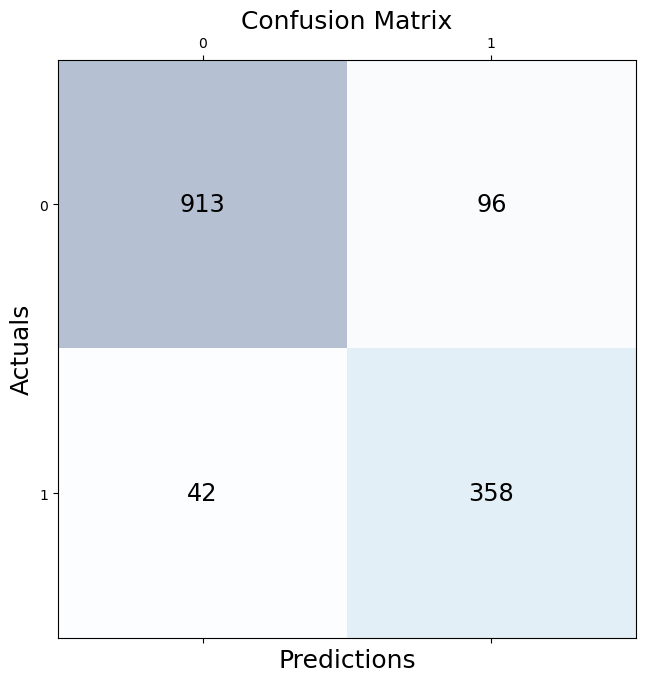

In [32]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [33]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_recall = recall_score(ground_truth_label.values, predict_label)
eval_auc = roc_auc_score(ground_truth_label.values, predict_label)
eval_f1 = f1_score(ground_truth_label.values, predict_label)

print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}{recall_score.__name__}{unbold}: {eval_recall}{newline}"
    f"{bold}{roc_auc_score.__name__}{unbold}: {eval_auc}{newline}"
    f"{bold}F1 {unbold}: {eval_f1}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.9020581973030518
recall_score: 0.895
roc_auc_score: 0.8999281466798811
F1 : 0.8384074941451991



---
Next, we delete the endpoint corresponding to the trained model.

---

In [34]:
# Delete the SageMaker endpoint and the attached resources
# predictor.delete_model()
predictor.delete_endpoint()